In [1]:
import sys, site

usp = site.getusersitepackages()
if usp in sys.path:
    sys.path.remove(usp)

print("USERSITE =", usp)
print("USERSITE in sys.path?", usp in sys.path)


USERSITE = C:\Users\ADMIN\AppData\Roaming\Python\Python311\site-packages
USERSITE in sys.path? False


In [2]:
import numpy as np, sys
print("PY =", sys.executable)
print("NP =", np.__version__)
print("NP_FILE =", np.__file__)


PY = C:\Users\ADMIN\.conda\envs\ndm_phase9\python.exe
NP = 1.26.4
NP_FILE = C:\Users\ADMIN\.conda\envs\ndm_phase9\Lib\site-packages\numpy\__init__.py


In [3]:
import sys, site
import numpy as np, sklearn, pandas as pd

print("PYTHON =", sys.executable)
print("PREFIX =", sys.prefix)
print("USERSITE =", site.getusersitepackages())
print("VERSIONS:", np.__version__, sklearn.__version__, pd.__version__)


PYTHON = C:\Users\ADMIN\.conda\envs\ndm_phase9\python.exe
PREFIX = C:\Users\ADMIN\.conda\envs\ndm_phase9
USERSITE = C:\Users\ADMIN\AppData\Roaming\Python\Python311\site-packages
VERSIONS: 1.26.4 1.8.0 2.3.3


In [4]:
import numpy as np, sklearn, pandas as pd
print(np.__version__, sklearn.__version__, pd.__version__)


1.26.4 1.8.0 2.3.3


In [5]:
import os, sys
PROJECT_ROOT = r"C:\Users\ADMIN\Desktop\NDM_Project"
os.chdir(PROJECT_ROOT)
print("CWD =", os.getcwd())


CWD = C:\Users\ADMIN\Desktop\NDM_Project


In [6]:
import os
for p in ["original_paper", "results/phase9", "results/cache_phase9", "src", "tests"]:
    os.makedirs(p, exist_ok=True)
print("OK folders")


OK folders


!pip -q install -U torch torchvision torchaudio
print("OK install")
Đã cài bằng conda, không chạy pip.


In [7]:
%%writefile original_paper/protocol.yaml
project:
  seed: 42

data:
  cwru_root: data/raw/CWRU
  fs_hz: 48000

  # 10 lớp: H + B/IR/OR (0.007/0.014/0.021)
  # OR chọn @6 để đúng 10 lớp (vì bạn có OR@3/@6/@12)
  classes_10:
    H: normal_baseline/Normal_1.mat
    B007: 48k_drive_end_fault/B007_1.mat
    B014: 48k_drive_end_fault/B014_1.mat
    B021: 48k_drive_end_fault/B021_1.mat
    IR007: 48k_drive_end_fault/IR007_1.mat
    IR014: 48k_drive_end_fault/IR014_1.mat
    IR021: 48k_drive_end_fault/IR021_1.mat
    OR007: 48k_drive_end_fault/OR007@6_1.mat
    OR014: 48k_drive_end_fault/OR014@6_1.mat
    OR021: 48k_drive_end_fault/OR021@6_1.mat

  sample_len: 4710
  samples_per_class: 100

  split:
    train_after_val_per_class: 64
    val_per_class: 16
    test_per_class: 20

preprocess:
  normalize: paper  # (x-mean)/max(|x|)
  spectrogram:
    n_fft: 512
    win_length: 512
    hop_length: 256   # 50% overlap
    mel_bins: 64
    log_eps: 1.0e-6
    target_frames: 96 # 96x64 đúng VGGish-form

features:
  shallow:
    lbp: { enabled: true, P: 8, R: 1, method: default }
    ldp: { enabled: true, k_top: 3 }
    lpq: { enabled: true, R_grid: [3, 5, 7] }
    mbh_lpq: { enabled: true, R: 7, b_grid: [1,2,4,6,8,10,12] }

  deep:
    # Nếu máy bạn bị lỗi VGGish do version torchaudio,
    # tắt vggish và dùng vgg16 làm deep vẫn chạy được Phase 9.
    vggish: { enabled: true }
    vgg16:  { enabled: true, layer: fc6 }

reduce_and_classify:
  pca: { enabled: true, n_components: 128 }
  eda: { enabled: true, reg_eps: 1.0e-6 }

fusion:
  ws_alpha_grid: [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

output:
  results_dir: results/phase9
  cache_dir: results/cache_phase9


Overwriting original_paper/protocol.yaml


In [8]:
%%writefile src/phase9_runner.py
import os
import json
import math
from dataclasses import dataclass
from typing import Dict, List

import numpy as np
import yaml
from scipy.io import loadmat
from scipy import linalg
from scipy.ndimage import convolve1d
from tqdm import tqdm

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt


def ensure_dir(p: str) -> None:
    os.makedirs(p, exist_ok=True)


def set_seed(seed: int) -> None:
    import random
    random.seed(seed)
    np.random.seed(seed)
    try:
        import torch
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    except Exception:
        pass


def find_1d_signal(mat: Dict) -> np.ndarray:
    cand = []
    for k, v in mat.items():
        if k.startswith("__"):
            continue
        if isinstance(v, np.ndarray) and np.issubdtype(v.dtype, np.number):
            a = np.squeeze(v)
            if a.ndim == 1 and a.size >= 1000:
                cand.append((a.size, k, a))
    if not cand:
        raise ValueError("Không tìm thấy tín hiệu 1D trong file .mat")
    cand.sort(key=lambda x: x[0], reverse=True)
    return cand[0][2].astype(np.float64)


def normalize_paper(x: np.ndarray) -> np.ndarray:
    x = x.astype(np.float64)
    x = x - x.mean()
    d = np.max(np.abs(x))
    if d < 1e-12:
        return x * 0.0
    return x / d


def segment_waveform(x: np.ndarray, seg_len: int, n_seg: int) -> np.ndarray:
    x = np.asarray(x).ravel()
    if x.size < seg_len:
        x = np.pad(x, (0, seg_len - x.size))
    max_start = max(0, x.size - seg_len)
    if max_start == 0:
        starts = np.zeros(n_seg, dtype=int)
    else:
        starts = np.linspace(0, max_start, num=n_seg, dtype=int)
    return np.stack([x[s:s + seg_len] for s in starts], axis=0)


def logmel_paper_like(x: np.ndarray, fs: int, n_fft: int, hop_length: int,
                     win_length: int, mel_bins: int, log_eps: float, target_frames: int) -> np.ndarray:
    import librosa

    S = librosa.feature.melspectrogram(
        y=x.astype(np.float32),
        sr=fs,
        n_fft=n_fft,
        hop_length=hop_length,
        win_length=win_length,
        window="hamming",
        center=False,
        power=2.0,
        n_mels=mel_bins,
        fmin=0.0,
        fmax=fs / 2,
    )
    S = np.log(S + log_eps).T  # (T, mel)

    T = S.shape[0]
    if T != target_frames:
        t_old = np.linspace(0.0, 1.0, num=T)
        t_new = np.linspace(0.0, 1.0, num=target_frames)
        out = np.empty((target_frames, S.shape[1]), dtype=np.float32)
        for m in range(S.shape[1]):
            out[:, m] = np.interp(t_new, t_old, S[:, m]).astype(np.float32)
    else:
        out = S.astype(np.float32)

    mn, mx = float(out.min()), float(out.max())
    if mx - mn > 1e-9:
        out = (out - mn) / (mx - mn)
    return out.astype(np.float32)  # (96,64)


def hist256(code_img: np.ndarray) -> np.ndarray:
    h = np.bincount(code_img.ravel().astype(np.int64), minlength=256).astype(np.float64)
    s = h.sum()
    if s > 0:
        h /= s
    return h


def lpq_code_image(img: np.ndarray, R: int) -> np.ndarray:
    img = img.astype(np.float64, copy=False)
    M = 2 * R + 1
    x = np.arange(-(M // 2), M // 2 + 1, dtype=np.float64)

    w0 = np.ones(M, dtype=np.complex128)
    w1 = np.exp(-2j * np.pi * x / M).astype(np.complex128)

    def filt_xy(wx, wy):
        tmp = convolve1d(img, wx, axis=1, mode="reflect")
        out = convolve1d(tmp, wy, axis=0, mode="reflect")
        return out

    F1 = filt_xy(w1, w0)
    F2 = filt_xy(w0, w1)
    F3 = filt_xy(w1, w1)
    F4 = filt_xy(w1, np.conj(w1))

    comps = [np.real(F1), np.imag(F1),
             np.real(F2), np.imag(F2),
             np.real(F3), np.imag(F3),
             np.real(F4), np.imag(F4)]
    bits = [(c >= 0).astype(np.uint8) for c in comps]

    code = np.zeros(img.shape, dtype=np.uint8)
    for i, b in enumerate(bits):
        code |= (b << i)
    return code


def basic_lpq_feature(img: np.ndarray, R: int) -> np.ndarray:
    return hist256(lpq_code_image(img, R=R))


def mbh_lpq_feature(img: np.ndarray, R: int, b: int) -> np.ndarray:
    code = lpq_code_image(img, R=R)
    blocks = np.array_split(code, b, axis=0)
    return np.concatenate([hist256(bl) for bl in blocks], axis=0)


def lbp_feature(img: np.ndarray, P: int, R: int, method: str) -> np.ndarray:
    from skimage.feature import local_binary_pattern
    lbp = local_binary_pattern(img, P=P, R=R, method=method).astype(np.uint8)
    return hist256(lbp)


def ldp_code_image(img: np.ndarray, k_top: int = 3) -> np.ndarray:
    img = img.astype(np.float32, copy=False)
    masks = [
        np.array([[5, 5, 5], [-3, 0, -3], [-3, -3, -3]], dtype=np.float32),
        np.array([[5, 5, -3], [5, 0, -3], [-3, -3, -3]], dtype=np.float32),
        np.array([[5, -3, -3], [5, 0, -3], [5, -3, -3]], dtype=np.float32),
        np.array([[-3, -3, -3], [5, 0, -3], [5, 5, -3]], dtype=np.float32),
        np.array([[-3, -3, -3], [-3, 0, -3], [5, 5, 5]], dtype=np.float32),
        np.array([[-3, -3, -3], [-3, 0, 5], [-3, 5, 5]], dtype=np.float32),
        np.array([[-3, -3, 5], [-3, 0, 5], [-3, -3, 5]], dtype=np.float32),
        np.array([[-3, 5, 5], [-3, 0, 5], [-3, -3, -3]], dtype=np.float32),
    ]
    H, W = img.shape
    pad = np.pad(img, ((1, 1), (1, 1)), mode="reflect")
    resp = np.zeros((8, H, W), dtype=np.float32)
    for i, K in enumerate(masks):
        r = (
            K[0, 0] * pad[0:H, 0:W] + K[0, 1] * pad[0:H, 1:W + 1] + K[0, 2] * pad[0:H, 2:W + 2] +
            K[1, 0] * pad[1:H + 1, 0:W] + K[1, 1] * pad[1:H + 1, 1:W + 1] + K[1, 2] * pad[1:H + 1, 2:W + 2] +
            K[2, 0] * pad[2:H + 2, 0:W] + K[2, 1] * pad[2:H + 2, 1:W + 1] + K[2, 2] * pad[2:H + 2, 2:W + 2]
        )
        resp[i] = r

    topk = np.argpartition(resp, -k_top, axis=0)[-k_top:]
    code = np.zeros((H, W), dtype=np.uint8)
    for j in range(k_top):
        idx = topk[j]
        code |= (1 << idx).astype(np.uint8)
    return code


def ldp_feature(img: np.ndarray, k_top: int) -> np.ndarray:
    return hist256(ldp_code_image(img, k_top=k_top))


def vggish_feature_from_waveform(x: np.ndarray, fs: int, device: str) -> np.ndarray:
    import torch
    import torchaudio

    # cố thử pipeline VGGISH của torchaudio
    try:
        from torchaudio.prototype.pipelines import VGGISH
        input_sr = VGGISH.sample_rate
        proc = VGGISH.get_input_processor()
        model = VGGISH.get_model().to(device)
        model.eval()
    except Exception as e:
        raise RuntimeError(
            "VGGish không chạy được do torchaudio version. "
            "Cách fix nhanh: vào protocol.yaml -> deep.vggish.enabled=false (dùng VGG16). "
            f"Chi tiết lỗi: {e}"
        )

    wav = torch.from_numpy(x.astype(np.float32))
    wav = torchaudio.functional.resample(wav, fs, input_sr)

    min_len = int(input_sr * 1.0)
    if wav.numel() < min_len:
        wav = torch.nn.functional.pad(wav, (0, min_len - wav.numel()))

    with torch.no_grad():
        ex = proc(wav.to(device))
        emb = model(ex)
        if emb.ndim == 2:
            emb = emb.mean(dim=0)
        else:
            emb = emb.reshape(-1).mean()
    return emb.detach().cpu().numpy().astype(np.float32).ravel()


def vgg16_feature_batch(logmels: np.ndarray, layer: str, device: str, batch_size: int = 32) -> np.ndarray:
    import torch
    import torchvision
    import torchvision.transforms as T

    weights = torchvision.models.VGG16_Weights.DEFAULT
    model = torchvision.models.vgg16(weights=weights).to(device)
    model.eval()

    norm = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    outs = []
    N = logmels.shape[0]
    for s in range(0, N, batch_size):
        x = torch.from_numpy(logmels[s:s + batch_size]).unsqueeze(1)
        x = torch.nn.functional.interpolate(x, size=(224, 224), mode="bilinear", align_corners=False)
        x = x.repeat(1, 3, 1, 1)
        x = norm(x)

        with torch.no_grad():
            f = model.features(x.to(device))
            f = model.avgpool(f)
            f = torch.flatten(f, 1)

            fc6 = model.classifier[2](model.classifier[1](model.classifier[0](f)))
            fc7 = model.classifier[5](model.classifier[4](model.classifier[3](fc6)))
            fc8 = model.classifier[6](fc7)

        if layer == "fc6":
            outs.append(fc6.cpu().numpy())
        elif layer == "fc7":
            outs.append(fc7.cpu().numpy())
        elif layer == "fc8":
            outs.append(fc8.cpu().numpy())
        else:
            raise ValueError("layer phải là fc6/fc7/fc8")

    return np.vstack(outs).astype(np.float32)


def fit_eda(X: np.ndarray, y: np.ndarray, reg_eps: float, n_components: int) -> np.ndarray:
    X = X.astype(np.float64)
    y = y.astype(np.int64)
    classes = np.unique(y)

    mu = X.mean(axis=0, keepdims=True)
    Sb = np.zeros((X.shape[1], X.shape[1]), dtype=np.float64)
    Sw = np.zeros_like(Sb)

    for c in classes:
        Xc = X[y == c]
        muc = Xc.mean(axis=0, keepdims=True)
        d = (muc - mu)
        Sb += Xc.shape[0] * (d.T @ d)
        X0 = Xc - muc
        Sw += (X0.T @ X0)

    Sw += reg_eps * np.eye(Sw.shape[0], dtype=np.float64)
    Sb = Sb / (np.trace(Sb) + 1e-12)
    Sw = Sw / (np.trace(Sw) + 1e-12)

    eSb = linalg.expm(Sb)
    eSw = linalg.expm(Sw)
    vals, vecs = linalg.eigh(eSb, eSw)
    idx = np.argsort(vals)[::-1]
    W = vecs[:, idx[:n_components]]
    return W.astype(np.float64)


def cosine_scores(Z: np.ndarray, cents: np.ndarray) -> np.ndarray:
    Z = Z.astype(np.float64)
    C = cents.astype(np.float64)
    Zn = np.linalg.norm(Z, axis=1, keepdims=True) + 1e-12
    Cn = np.linalg.norm(C, axis=1, keepdims=True) + 1e-12
    return (Z / Zn) @ (C / Cn).T


def train_eval_branch(Xtr, ytr, Xva, yva, Xte, yte, pca_dim: int,
                      use_pca: bool, use_eda: bool, reg_eps: float, seed: int):
    classes = np.unique(ytr)

    if use_pca:
        pca = PCA(n_components=min(pca_dim, Xtr.shape[1]), random_state=seed)
        Xtr2 = pca.fit_transform(Xtr)
        Xva2 = pca.transform(Xva)
        Xte2 = pca.transform(Xte)
    else:
        Xtr2, Xva2, Xte2 = Xtr, Xva, Xte

    if use_eda:
        n_comp = min(len(classes) - 1, Xtr2.shape[1])
        W = fit_eda(Xtr2, ytr, reg_eps=reg_eps, n_components=n_comp)
        Ztr = Xtr2 @ W
        Zva = Xva2 @ W
        Zte = Xte2 @ W
    else:
        Ztr, Zva, Zte = Xtr2, Xva2, Xte2

    cents = np.vstack([Ztr[ytr == c].mean(axis=0) for c in classes])
    s_va = cosine_scores(Zva, cents)
    s_te = cosine_scores(Zte, cents)

    yhat_va = classes[np.argmax(s_va, axis=1)]
    yhat_te = classes[np.argmax(s_te, axis=1)]

    return {
        "scores_val": s_va,
        "scores_test": s_te,
        "yhat_val": yhat_va,
        "yhat_test": yhat_te,
        "acc_val": float(accuracy_score(yva, yhat_va)),
        "acc_test": float(accuracy_score(yte, yhat_te)),
        "f1_val": float(f1_score(yva, yhat_va, average="macro")),
        "f1_test": float(f1_score(yte, yhat_te, average="macro")),
    }


@dataclass
class SplitData:
    X_train: np.ndarray
    y_train: np.ndarray
    X_val: np.ndarray
    y_val: np.ndarray
    X_test: np.ndarray
    y_test: np.ndarray
    class_names: List[str]


def build_cwru_splits(cfg: dict, project_root: str) -> SplitData:
    root = os.path.join(project_root, cfg["data"]["cwru_root"])
    fs = int(cfg["data"]["fs_hz"])
    seg_len = int(cfg["data"]["sample_len"])
    n_seg = int(cfg["data"]["samples_per_class"])

    n_tr = int(cfg["data"]["split"]["train_after_val_per_class"])
    n_val = int(cfg["data"]["split"]["val_per_class"])
    n_te = int(cfg["data"]["split"]["test_per_class"])

    classes_map = cfg["data"]["classes_10"]
    class_names = list(classes_map.keys())

    Xtr, ytr, Xva, yva, Xte, yte = [], [], [], [], [], []

    for ci, cname in enumerate(class_names):
        fpath = os.path.join(root, classes_map[cname])
        mat = loadmat(fpath)
        sig = find_1d_signal(mat)

        segs = segment_waveform(sig, seg_len=seg_len, n_seg=n_seg)
        segs = np.stack([normalize_paper(s) for s in segs], axis=0)

        Xtr.append(segs[:n_tr]);                 ytr.append(np.full(n_tr, ci, dtype=np.int64))
        Xva.append(segs[n_tr:n_tr+n_val]);       yva.append(np.full(n_val, ci, dtype=np.int64))
        Xte.append(segs[n_tr+n_val:n_tr+n_val+n_te]); yte.append(np.full(n_te, ci, dtype=np.int64))

    return SplitData(
        X_train=np.concatenate(Xtr, axis=0),
        y_train=np.concatenate(ytr, axis=0),
        X_val=np.concatenate(Xva, axis=0),
        y_val=np.concatenate(yva, axis=0),
        X_test=np.concatenate(Xte, axis=0),
        y_test=np.concatenate(yte, axis=0),
        class_names=class_names,
    )


def run_phase9(protocol_path: str = "original_paper/protocol.yaml") -> None:
    project_root = os.getcwd()
    with open(protocol_path, "r", encoding="utf-8") as f:
        cfg = yaml.safe_load(f)

    seed = int(cfg["project"]["seed"])
    set_seed(seed)

    out_dir = cfg["output"]["results_dir"]
    cache_dir = cfg["output"]["cache_dir"]
    ensure_dir(out_dir)
    ensure_dir(cache_dir)
    ensure_dir(os.path.join(out_dir, "audit"))

    device = "cpu"
    try:
        import torch
        device = "cuda" if torch.cuda.is_available() else "cpu"
    except Exception:
        pass

    split = build_cwru_splits(cfg, project_root)
    fs = int(cfg["data"]["fs_hz"])

    sp = cfg["preprocess"]["spectrogram"]
    def npy(name): return os.path.join(cache_dir, name)

    if not os.path.isfile(npy("logmel_train.npy")):
        print("[Phase9] Extract log-mel (paper-like)...")
        logmel_train = np.stack([logmel_paper_like(x, fs, **sp) for x in tqdm(split.X_train)], axis=0)
        logmel_val   = np.stack([logmel_paper_like(x, fs, **sp) for x in tqdm(split.X_val)], axis=0)
        logmel_test  = np.stack([logmel_paper_like(x, fs, **sp) for x in tqdm(split.X_test)], axis=0)
        np.save(npy("logmel_train.npy"), logmel_train)
        np.save(npy("logmel_val.npy"), logmel_val)
        np.save(npy("logmel_test.npy"), logmel_test)
    else:
        logmel_train = np.load(npy("logmel_train.npy"))
        logmel_val   = np.load(npy("logmel_val.npy"))
        logmel_test  = np.load(npy("logmel_test.npy"))

    plt.figure(figsize=(5,3))
    plt.imshow(logmel_train[0].T, aspect="auto", origin="lower")
    plt.title("Audit log-mel (paper-like)")
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, "audit", "logmel_example.png"), dpi=200)
    plt.close()

    use_pca = bool(cfg["reduce_and_classify"]["pca"]["enabled"])
    pca_dim = int(cfg["reduce_and_classify"]["pca"]["n_components"])
    use_eda = bool(cfg["reduce_and_classify"]["eda"]["enabled"])
    reg_eps = float(cfg["reduce_and_classify"]["eda"]["reg_eps"])

    rows = []
    sh = cfg["features"]["shallow"]

    if sh["lbp"]["enabled"]:
        P = int(sh["lbp"]["P"]); R = int(sh["lbp"]["R"]); method = str(sh["lbp"]["method"])
        print("[Phase9] LBP...")
        Xtr = np.stack([lbp_feature(im, P, R, method) for im in tqdm(logmel_train)], axis=0)
        Xva = np.stack([lbp_feature(im, P, R, method) for im in tqdm(logmel_val)], axis=0)
        Xte = np.stack([lbp_feature(im, P, R, method) for im in tqdm(logmel_test)], axis=0)
        res = train_eval_branch(Xtr, split.y_train, Xva, split.y_val, Xte, split.y_test, pca_dim, use_pca, use_eda, reg_eps, seed)
        rows.append({"model":"LBP", **{k:res[k] for k in ["acc_val","acc_test","f1_val","f1_test"]}})

    if sh["ldp"]["enabled"]:
        k_top = int(sh["ldp"]["k_top"])
        print("[Phase9] LDP...")
        Xtr = np.stack([ldp_feature(im, k_top) for im in tqdm(logmel_train)], axis=0)
        Xva = np.stack([ldp_feature(im, k_top) for im in tqdm(logmel_val)], axis=0)
        Xte = np.stack([ldp_feature(im, k_top) for im in tqdm(logmel_test)], axis=0)
        res = train_eval_branch(Xtr, split.y_train, Xva, split.y_val, Xte, split.y_test, pca_dim, use_pca, use_eda, reg_eps, seed)
        rows.append({"model":"LDP", **{k:res[k] for k in ["acc_val","acc_test","f1_val","f1_test"]}})

    if sh["lpq"]["enabled"]:
        for Rlpq in sh["lpq"]["R_grid"]:
            Rlpq = int(Rlpq)
            print(f"[Phase9] LPQ R={Rlpq}...")
            Xtr = np.stack([basic_lpq_feature(im, Rlpq) for im in tqdm(logmel_train)], axis=0)
            Xva = np.stack([basic_lpq_feature(im, Rlpq) for im in tqdm(logmel_val)], axis=0)
            Xte = np.stack([basic_lpq_feature(im, Rlpq) for im in tqdm(logmel_test)], axis=0)
            res = train_eval_branch(Xtr, split.y_train, Xva, split.y_val, Xte, split.y_test, pca_dim, use_pca, use_eda, reg_eps, seed)
            rows.append({"model":f"LPQ_R{Rlpq}", **{k:res[k] for k in ["acc_val","acc_test","f1_val","f1_test"]}})

    mbh = sh["mbh_lpq"]
    Rm = int(mbh["R"])
    b_grid = [int(x) for x in mbh["b_grid"]]

    best_b, best_val = None, -1.0
    best_mbh_val_scores, best_mbh_test_scores = None, None
    b_rows = []

    for b in b_grid:
        print(f"[Phase9] MBH-LPQ R={Rm}, b={b}...")
        Xtr = np.stack([mbh_lpq_feature(im, Rm, b) for im in tqdm(logmel_train)], axis=0)
        Xva = np.stack([mbh_lpq_feature(im, Rm, b) for im in tqdm(logmel_val)], axis=0)
        Xte = np.stack([mbh_lpq_feature(im, Rm, b) for im in tqdm(logmel_test)], axis=0)
        res = train_eval_branch(Xtr, split.y_train, Xva, split.y_val, Xte, split.y_test, pca_dim, use_pca, use_eda, reg_eps, seed)
        b_rows.append({"b":b, "acc_val":res["acc_val"], "acc_test":res["acc_test"]})
        if res["acc_val"] > best_val:
            best_val = res["acc_val"]
            best_b = b
            best_mbh_val_scores = res["scores_val"]
            best_mbh_test_scores = res["scores_test"]

    np.savetxt(os.path.join(out_dir, "b_sweep.csv"),
               np.array([[r["b"], r["acc_val"], r["acc_test"]] for r in b_rows]),
               delimiter=",", header="b,acc_val,acc_test", comments="")

    plt.figure()
    plt.plot([r["b"] for r in b_rows], [r["acc_val"] for r in b_rows], marker="o", label="val")
    plt.plot([r["b"] for r in b_rows], [r["acc_test"] for r in b_rows], marker="o", label="test")
    plt.xlabel("b (sub-blocks)"); plt.ylabel("Accuracy"); plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, "b_sweep_plot.png"), dpi=200)
    plt.close()

    deep = cfg["features"]["deep"]
    deep_scores_val = None
    deep_scores_test = None
    deep_name = None

    if deep["vggish"]["enabled"]:
        print("[Phase9] VGGish...")
        cache = os.path.join(cache_dir, "vggish_train.npy")
        if not os.path.isfile(cache):
            Xtr = np.stack([vggish_feature_from_waveform(x, fs, device) for x in tqdm(split.X_train)], axis=0)
            Xva = np.stack([vggish_feature_from_waveform(x, fs, device) for x in tqdm(split.X_val)], axis=0)
            Xte = np.stack([vggish_feature_from_waveform(x, fs, device) for x in tqdm(split.X_test)], axis=0)
            np.save(os.path.join(cache_dir, "vggish_train.npy"), Xtr)
            np.save(os.path.join(cache_dir, "vggish_val.npy"), Xva)
            np.save(os.path.join(cache_dir, "vggish_test.npy"), Xte)
        else:
            Xtr = np.load(os.path.join(cache_dir, "vggish_train.npy"))
            Xva = np.load(os.path.join(cache_dir, "vggish_val.npy"))
            Xte = np.load(os.path.join(cache_dir, "vggish_test.npy"))

        res = train_eval_branch(Xtr, split.y_train, Xva, split.y_val, Xte, split.y_test, pca_dim, use_pca, use_eda, reg_eps, seed)
        rows.append({"model":"VGGish", **{k:res[k] for k in ["acc_val","acc_test","f1_val","f1_test"]}})
        deep_scores_val, deep_scores_test = res["scores_val"], res["scores_test"]
        deep_name = "VGGish"

    if deep["vgg16"]["enabled"]:
        layer = str(deep["vgg16"]["layer"])
        print(f"[Phase9] VGG16_{layer}...")
        cache = os.path.join(cache_dir, f"vgg16_{layer}_train.npy")
        if not os.path.isfile(cache):
            Xtr = vgg16_feature_batch(logmel_train, layer=layer, device=device, batch_size=32)
            Xva = vgg16_feature_batch(logmel_val, layer=layer, device=device, batch_size=32)
            Xte = vgg16_feature_batch(logmel_test, layer=layer, device=device, batch_size=32)
            np.save(os.path.join(cache_dir, f"vgg16_{layer}_train.npy"), Xtr)
            np.save(os.path.join(cache_dir, f"vgg16_{layer}_val.npy"), Xva)
            np.save(os.path.join(cache_dir, f"vgg16_{layer}_test.npy"), Xte)
        else:
            Xtr = np.load(os.path.join(cache_dir, f"vgg16_{layer}_train.npy"))
            Xva = np.load(os.path.join(cache_dir, f"vgg16_{layer}_val.npy"))
            Xte = np.load(os.path.join(cache_dir, f"vgg16_{layer}_test.npy"))

        res = train_eval_branch(Xtr, split.y_train, Xva, split.y_val, Xte, split.y_test, pca_dim, use_pca, use_eda, reg_eps, seed)
        rows.append({"model":f"VGG16_{layer}", **{k:res[k] for k in ["acc_val","acc_test","f1_val","f1_test"]}})
        if deep_scores_val is None:
            deep_scores_val, deep_scores_test = res["scores_val"], res["scores_test"]
            deep_name = f"VGG16_{layer}"

    if deep_scores_val is None:
        raise RuntimeError("Không có deep branch nào chạy được (VGGish/VGG16).")

    alpha_grid = [float(a) for a in cfg["fusion"]["ws_alpha_grid"]]
    best_alpha, best_ws_val = None, -1.0
    best_pred_test = None
    classes = np.unique(split.y_train)

    ws_rows = []
    for a in alpha_grid:
        s_val = (1.0 - a) * best_mbh_val_scores + a * deep_scores_val
        s_te  = (1.0 - a) * best_mbh_test_scores + a * deep_scores_test
        yhat_val = classes[np.argmax(s_val, axis=1)]
        yhat_te  = classes[np.argmax(s_te, axis=1)]
        acc_val = float(accuracy_score(split.y_val, yhat_val))
        acc_te = float(accuracy_score(split.y_test, yhat_te))
        ws_rows.append({"alpha":a, "acc_val":acc_val, "acc_test":acc_te})
        if acc_val > best_ws_val:
            best_ws_val = acc_val
            best_alpha = a
            best_pred_test = yhat_te

    np.savetxt(os.path.join(out_dir, "ws_sweep.csv"),
               np.array([[r["alpha"], r["acc_val"], r["acc_test"]] for r in ws_rows]),
               delimiter=",", header="alpha,acc_val,acc_test", comments="")

    plt.figure()
    plt.plot([r["alpha"] for r in ws_rows], [r["acc_val"] for r in ws_rows], marker="o", label="val")
    plt.plot([r["alpha"] for r in ws_rows], [r["acc_test"] for r in ws_rows], marker="o", label="test")
    plt.xlabel("alpha (weight deep)"); plt.ylabel("Accuracy"); plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, "ws_sweep_plot.png"), dpi=200)
    plt.close()

    cm = confusion_matrix(split.y_test, best_pred_test, labels=classes)
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation="nearest")
    plt.title(f"Confusion Matrix (alpha={best_alpha:.2f}, deep={deep_name}, b={best_b})")
    plt.colorbar()
    tick = np.arange(len(split.class_names))
    plt.xticks(tick, split.class_names, rotation=45, ha="right")
    plt.yticks(tick, split.class_names)
    plt.tight_layout()
    plt.xlabel("Pred"); plt.ylabel("True")
    plt.savefig(os.path.join(out_dir, "cm_paper_core.png"), dpi=200)
    plt.close()

    import pandas as pd
    df = pd.DataFrame(rows)
    df.to_csv(os.path.join(out_dir, "paper_core_metrics.csv"), index=False)

    with open(os.path.join(out_dir, "best.json"), "w", encoding="utf-8") as f:
        json.dump({"best_b": int(best_b), "best_alpha": float(best_alpha), "deep_branch": deep_name}, f, indent=2)

    tex = os.path.join(out_dir, "paper_core_table.tex")
    with open(tex, "w", encoding="utf-8") as f:
        f.write("\\begin{table}[t]\\centering\\small\n")
        f.write("\\begin{tabular}{lcc}\\toprule\n")
        f.write("Model & Acc(val) & Acc(test)\\\\ \\midrule\n")
        for _, r in df.iterrows():
            av = r.get("acc_val", None); at = r.get("acc_test", None)
            avs = "-" if av is None or (isinstance(av, float) and math.isnan(av)) else f"{av*100:.2f}"
            ats = "-" if at is None or (isinstance(at, float) and math.isnan(at)) else f"{at*100:.2f}"
            f.write(f"{r['model']} & {avs} & {ats}\\\\\n")
        f.write("\\bottomrule\\end{tabular}\n")
        f.write("\\caption{Phase 9 reproduction summary.}\\end{table}\n")

    print("[Phase9] DONE ->", out_dir)


Overwriting src/phase9_runner.py


In [9]:
%%writefile original_paper/method_sciRep_like.py
from src.phase9_runner import run_phase9

if __name__ == "__main__":
    run_phase9("original_paper/protocol.yaml")


Overwriting original_paper/method_sciRep_like.py


In [10]:
%run original_paper/method_sciRep_like.py


[Phase9] Extract log-mel (paper-like)...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 267.19it/s]


[Phase9] LBP...


  0%|                                                                                                                                          | 0/640 [00:00<?, ?it/s]C:\Users\ADMIN\.conda\envs\ndm_phase9\Lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 350.53it/s]


[Phase9] LDP...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 375.57it/s]


[Phase9] LPQ R=3...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 382.39it/s]


[Phase9] LPQ R=5...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 226.15it/s]


[Phase9] LPQ R=7...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 337.93it/s]


[Phase9] MBH-LPQ R=7, b=1...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 272.33it/s]


[Phase9] MBH-LPQ R=7, b=2...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 236.05it/s]


[Phase9] MBH-LPQ R=7, b=4...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 250.67it/s]


[Phase9] MBH-LPQ R=7, b=6...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 316.30it/s]


[Phase9] MBH-LPQ R=7, b=8...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 307.04it/s]


[Phase9] MBH-LPQ R=7, b=10...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 305.46it/s]


[Phase9] MBH-LPQ R=7, b=12...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 306.88it/s]


[Phase9] VGGish...


  0%|                                                                                                                                          | 0/640 [00:00<?, ?it/s]
  0%|                                                                                                                                       | 0.00/275M [00:00<?, ?B/s]
  0%|                                                                                                                                | 128k/275M [00:00<15:36, 308kB/s]
  0%|                                                                                                                                | 256k/275M [00:00<11:13, 428kB/s]
  0%|▏                                                                                                                               | 384k/275M [00:00<09:26, 509kB/s]
  0%|▎                                                                                                                               | 768k/275M [00:01<04:53, 9

[Phase9] VGG16_fc6...


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\ADMIN/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 528M/528M [01:36<00:00, 5.75MB/s]


[Phase9] DONE -> results/phase9


In [11]:
from pathlib import Path
out = Path("results/phase9")
print("OUT =", out.resolve())
print("Exists?", out.exists())

# liệt kê nhanh vài file/thu muc
items = sorted(out.rglob("*"))
print("Total items:", len(items))
for p in items[:50]:
    print(p.relative_to(out))


OUT = C:\Users\ADMIN\Desktop\NDM_Project\results\phase9
Exists? True
Total items: 10
audit
audit\logmel_example.png
b_sweep.csv
b_sweep_plot.png
best.json
cm_paper_core.png
paper_core_metrics.csv
paper_core_table.tex
ws_sweep.csv
ws_sweep_plot.png


In [12]:
import glob
for ext in ["npy","npz","csv","json","png","pkl","pt"]:
    n = len(glob.glob(f"results/phase9/**/*.{ext}", recursive=True))
    print(f"{ext}: {n}")


npy: 0
npz: 0
csv: 3
json: 1
png: 4
pkl: 0
pt: 0


In [13]:
import os, re
from pathlib import Path

out = Path("results/phase9")
cands = [p for p in out.rglob("*") if p.suffix.lower() in [".json",".txt",".csv"]]
cands = [p for p in cands if re.search(r"(summary|metric|result|report|score)", p.name.lower())]
print("Candidates:", len(cands))
for p in cands[:20]:
    print(p.relative_to(out))

# thử đọc json đầu tiên (nếu có)
jsons = [p for p in cands if p.suffix.lower()==".json"]
if jsons:
    import json
    p = jsons[0]
    print("\nREAD:", p)
    print(json.dumps(json.loads(p.read_text(encoding="utf-8")), indent=2)[:2000])


Candidates: 1
paper_core_metrics.csv


In [14]:
from pathlib import Path
import json
import pandas as pd

out = Path("results/phase9")

df = pd.read_csv(out/"paper_core_metrics.csv")
print("Columns:", list(df.columns))

# tự tìm cột accuracy (đỡ phụ thuộc tên cột)
acc_col = next((c for c in df.columns if c.lower() in ["acc", "accuracy", "test_acc", "val_acc"]), None)
if acc_col:
    display(df.sort_values(acc_col, ascending=False).head(20))
else:
    display(df.head(20))

best = json.loads((out/"best.json").read_text(encoding="utf-8"))
print("BEST JSON:")
print(best)


Columns: ['model', 'acc_val', 'acc_test', 'f1_val', 'f1_test']


,model,acc_val,acc_test,f1_val,f1_test
0,LBP,0.78125,0.785,0.778167,0.778615
1,LDP,0.53125,0.560,0.508420,0.530168
2,LPQ_R3,0.87500,0.870,0.872135,0.865042
3,LPQ_R5,0.91875,0.930,0.916654,0.930604
4,LPQ_R7,0.94375,0.955,0.944110,0.954803
5,VGGish,0.84375,0.805,0.835619,0.796888
6,VGG16_fc6,0.96875,0.960,0.968719,0.959495


BEST JSON:
{'best_b': 1, 'best_alpha': 0.4, 'deep_branch': 'VGGish'}


In [15]:
import pandas as pd
from pathlib import Path

out = Path("results/phase9")

print("== b_sweep ==")
display(pd.read_csv(out/"b_sweep.csv").head(30))

print("== ws_sweep ==")
display(pd.read_csv(out/"ws_sweep.csv").head(30))


== b_sweep ==


,b,acc_val,acc_test
0,1.0,0.94375,0.955
1,2.0,0.93750,0.920
2,4.0,0.91875,0.825
3,6.0,0.71250,0.685
4,8.0,0.58750,0.620
5,10.0,0.53125,0.570
6,12.0,0.50000,0.550


== ws_sweep ==


,alpha,acc_val,acc_test
0,0.1,0.96875,0.970
1,0.2,0.96875,0.965
2,0.3,0.97500,0.965
3,0.4,0.98125,0.965
4,0.5,0.96250,0.965
5,0.6,0.95000,0.950
6,0.7,0.93125,0.935
7,0.8,0.90000,0.905
8,0.9,0.88750,0.855


,model,acc_val,acc_test,f1_val,f1_test
0,LBP,0.78125,0.785,0.778167,0.778615
1,LDP,0.53125,0.560,0.508420,0.530168
2,LPQ_R3,0.87500,0.870,0.872135,0.865042
3,LPQ_R5,0.91875,0.930,0.916654,0.930604
4,LPQ_R7,0.94375,0.955,0.944110,0.954803
5,VGGish,0.84375,0.805,0.835619,0.796888
6,VGG16_fc6,0.96875,0.960,0.968719,0.959495


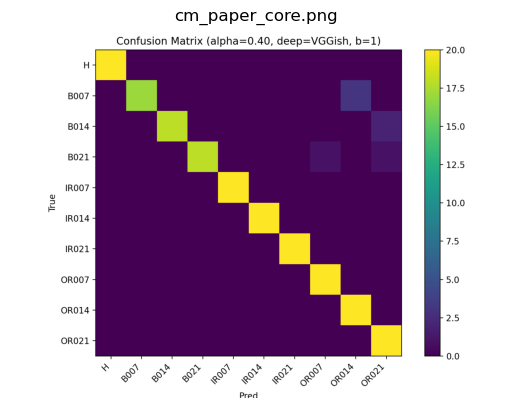

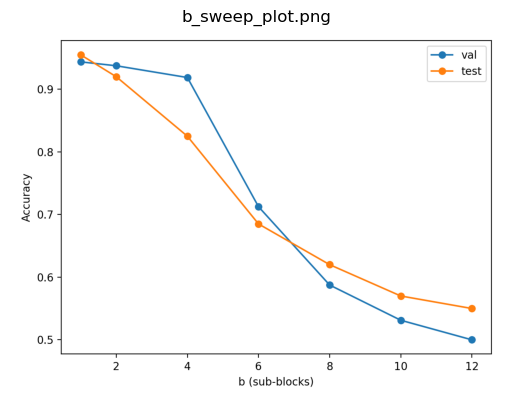

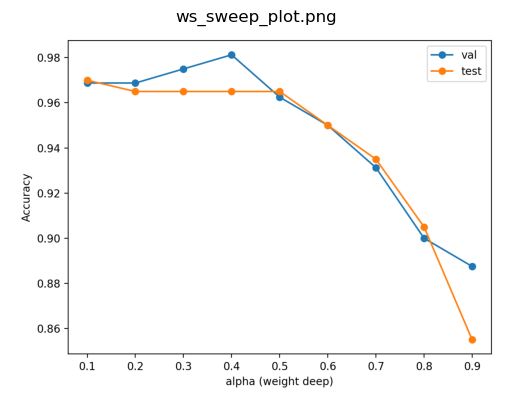

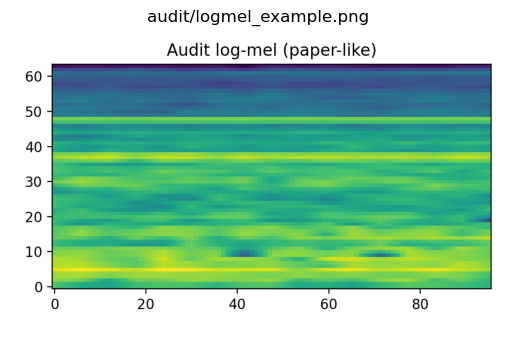

In [16]:
from pathlib import Path
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

out = Path("results/phase9")
display(pd.read_csv(out/"paper_core_metrics.csv"))

for fn in ["cm_paper_core.png","b_sweep_plot.png","ws_sweep_plot.png","audit/logmel_example.png"]:
    p = out/fn
    if p.exists():
        img = Image.open(p)
        plt.figure()
        plt.imshow(img)
        plt.axis("off")
        plt.title(fn)
        plt.show()
